In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

In [2]:
dep_var_name = 'Murder and nonnegligent manslaughter'
other_crime_colnames = ['Murder_count','Aggravated assault','Burglary','Counties/principal cities','Larceny','Motor vehicle theft','Murder and nonnegligent manslaughter','Property crime','Rape','Robbery','Violent crime']
other_crime_colnames.remove(dep_var_name)

In [3]:
#read in
all_df = pd.read_csv('data/derived/crime_ACS_merged.csv', low_memory=False)
print(all_df.shape)
all_df.columns  # [:20]
all_df.head(3)

(3283, 564)


,Aggravated assault,Burglary,Counties/principal cities,Larceny,Motor vehicle theft,Murder and nonnegligent manslaughter,Population,Property crime,Rape,Robbery,...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later
0,227.8,649.9,"Rate per 100,000 inhabitants",2077.9,175.4,6.5,NaN,2903.1,46.5,80.6,...,9.5,8.4,18.6,11.1,15.0,15.5,8.6,9.3,2.6,1.5
1,121.0,563.3,"Rate per 100,000 inhabitants",1857.3,144.0,6.0,NaN,2564.5,48.9,77.3,...,19.0,7.2,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6
2,534.9,949.8,"Rate per 100,000 inhabitants",2676.9,144.2,11.8,NaN,3770.8,28.2,159.9,...,6.2,3.2,9.7,14.0,15.2,15.4,17.0,16.9,1.9,0.3


In [4]:
#Non-numeric columns, missing dependent variable, other crime data

#TODO: un-hackify this
#all columns to numeric
for col in all_df.columns.values:
    all_df.loc[:, col] = pd.to_numeric(all_df[col], errors='coerce')

#drop columns with many NaN (likely those that were text data)
bad_cols = all_df.isnull().sum() > 100
all_df = all_df.loc[:, ~bad_cols]


#deal with missing dependent variable (by dropping those rows)
missing_dv = all_df[dep_var_name].isnull()
all_df = all_df.loc[~missing_dv, :]

#Drop crime data that isn't the dependent variable (using that data is prettymuch cheating)
all_df=all_df[all_df.columns.difference(other_crime_colnames)]

print(all_df.shape)
all_df.head()

(3283, 336)


,Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Mean household income (dollars),Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars),Estimate; SEX AND AGE - Median age (years),Id2,Murder and nonnegligent manslaughter,Percent; ANCESTRY - Total population,Percent; ANCESTRY - Total population - American,Percent; ANCESTRY - Total population - Arab,Percent; ANCESTRY - Total population - Czech,Percent; ANCESTRY - Total population - Danish,...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later,msa_pop,year
0,62145,48016,34.4,10180,6.5,170860.0,6.0,0.0,0.1,0.1,...,18.6,11.1,15.0,15.5,8.6,9.3,2.6,1.5,169885,2016
1,70083,51598,40.2,10420,6.0,702221.0,10.1,1.5,1.0,0.1,...,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6,703561,2016
2,57901,40667,36.4,10500,11.8,152506.0,15.1,0.0,0.0,0.0,...,9.7,14.0,15.2,15.4,17.0,16.9,1.9,0.3,152566,2016
3,69891,51310,39.4,10540,0.0,122849.0,6.2,0.8,0.4,0.6,...,8.7,9.7,20.9,7.9,16.8,12.9,2.5,1.1,122030,2016
4,85684,65855,39.8,10580,2.0,881839.0,4.3,0.8,0.4,0.4,...,9.8,8.9,11.3,12.1,9.6,8.9,2.8,0.9,878166,2016


In [5]:
#train/test split

x_data=all_df[all_df.columns.difference([dep_var_name])]
y_data=all_df[dep_var_name]

train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
train_x.shape

(2298, 335)

In [6]:
#Deal with missing column entries
def impute_missing(train_data, test_data):
    #TODO: better handling of missing items in the remainging columns
    train_means = train_data.mean().to_dict()
    
    imputed_train = train_data.fillna(train_means, axis=0)
    imputed_test = test_data.fillna(train_means, axis=0)
    
    #note: does not change the input data, just returns the updated result
    return imputed_train,imputed_test


#PCA to reduce dimension
def do_PCA_transform(train_data, test_data, percent_explained):

    imputed_train, imputed_test = impute_missing(train_data, test_data)
    
    scaler = StandardScaler().fit(imputed_train)
    imputed_train = scaler.transform(imputed_train)
    imputed_test = scaler.transform(imputed_test)

    
    pca = PCA(n_components=percent_explained).fit(imputed_train)
    
    pca_train_data = pca.transform(imputed_train)
    pca_test_data = pca.transform(imputed_test)

    return pca_train_data,pca_test_data

do_PCA_transform(train_x, test_x,.8)[0].shape

(2298, 33)

In [7]:
#CV to pick a ridge regression model
cv_folds=5
pca_values = [.3,.4,.5,.6,.7,.8,.9,.99]
alpha_values = np.logspace(-5,5)

cv_scores = np.zeros((cv_folds, len(pca_values), len(alpha_values)))


kf = KFold(n_splits=cv_folds, random_state=3, shuffle=False)
cv_index = -1
for train_index, test_index in kf.split(train_x):
    cv_index += 1
    print("Working on CV fold",cv_index)
    cv_train_x, cv_test_x = train_x.iloc[train_index,:], train_x.iloc[test_index,:]
    cv_train_y, cv_test_y = train_y.iloc[train_index], train_y.iloc[test_index]

    for pca_index, cur_percent_explained in enumerate(pca_values):
        #fit the PCA
        pca_cv_train_x, pca_cv_test_x = do_PCA_transform(cv_train_x, cv_test_x, 
                                                         cur_percent_explained)

        for alpha_index, cur_alpha in enumerate(alpha_values):
            #fit the model
            fitted_model = Lasso(alpha=cur_alpha).fit(pca_cv_train_x,cv_train_y)

            #store the result
            cv_scores[cv_index, pca_index, alpha_index] = fitted_model.score(pca_cv_test_x, cv_test_y)
print("Done")

Working on CV fold 0
Working on CV fold 1
Working on CV fold 2
Working on CV fold 3
Working on CV fold 4
Done


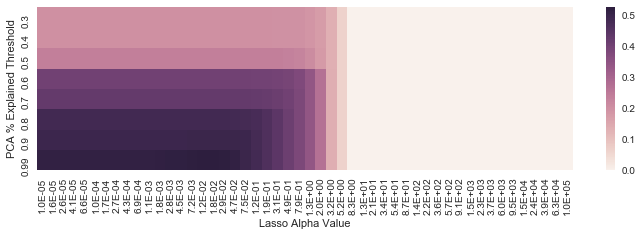

In [8]:
#means and SDs
means = pd.DataFrame(cv_scores.mean(axis=(0)), index=pca_values, columns=alpha_values)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sns.heatmap(means, xticklabels=[format(v, '1.1E') for v in alpha_values], ax=ax, vmin=0)
plt.xlabel('Lasso Alpha Value')
plt.ylabel('PCA % Explained Threshold')
plt.show()

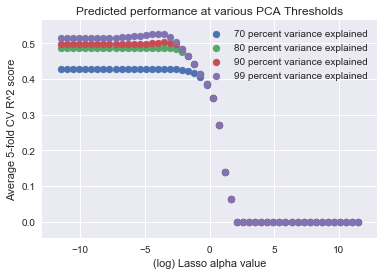

In [9]:
#plot of falloff
for x in range(4,8):
    plt.scatter(np.log(means.iloc[x,:].index), means.iloc[x,:])
plt.legend(["{:0.0f}".format(100*x)+" percent variance explained" for x in pca_values[4:8]])
plt.title("Predicted performance at various PCA Thresholds")
plt.ylabel('Average 5-fold CV R^2 score')
plt.xlabel('(log) Lasso alpha value')
plt.show()

In [10]:
#get optimal params, fit to whole data
best_pca_percent_index, best_alpha_index = np.unravel_index(np.argmax(means.values), means.shape)

#fit the model to the whole data
pca_train_x, pca_test_x = do_PCA_transform(train_x, test_x, pca_values[best_pca_percent_index])
fitted_model = Lasso(alpha=alpha_values[best_alpha_index]).fit(pca_train_x,train_y)

fitted_model.score(pca_train_x,train_y)#for proof it works

0.59627593418038305

In the above we see that that any PCA percent above .8 and basically any alpha value works well, provided the alpha isn't too big. There is a severe cascade where incresing alpha reduces to guessing the mean of the trainng data, regardless of the PCA setting, earning a lower-than-zero R^2 score in the cv test set.

Within the mode of the CV performances, PCAs with high amounts of variance captured show a small bump in performance just before the constrain-to-mean dropoff kicks in. This seems to be the 'sweet spot' tuning, where there is some amount of regularization applied, but not so much as to bias the model strongly towards a flat line.

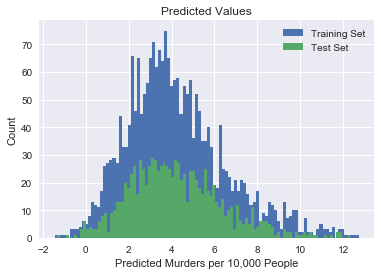

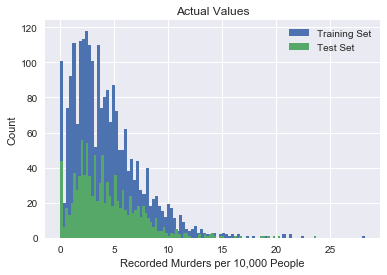

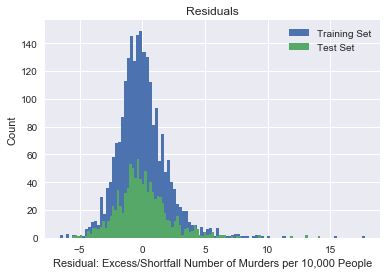

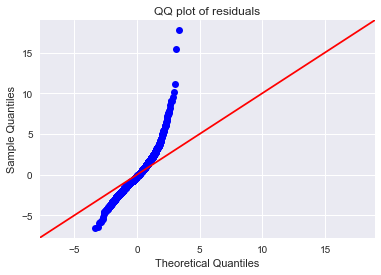

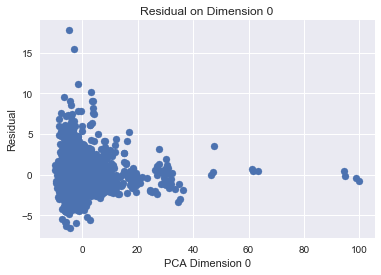

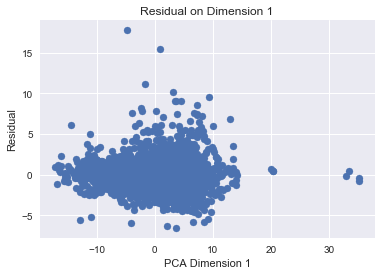

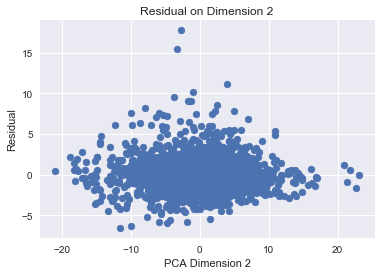

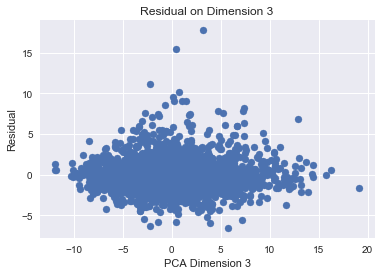

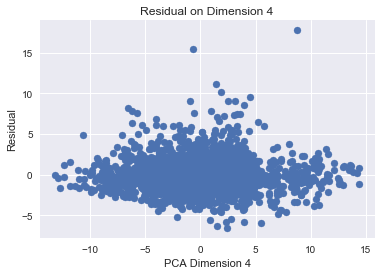

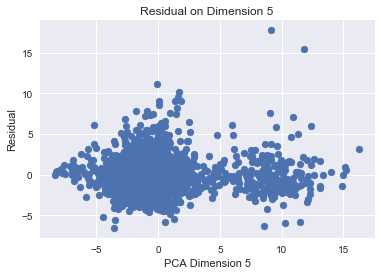

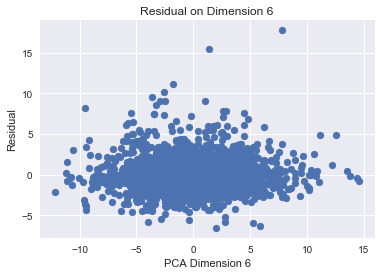

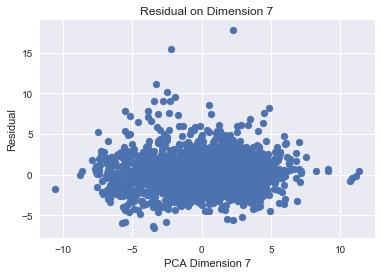

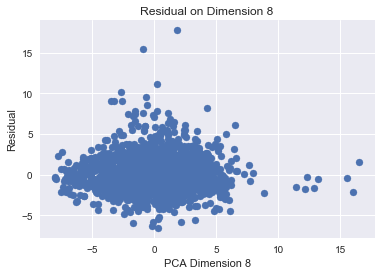

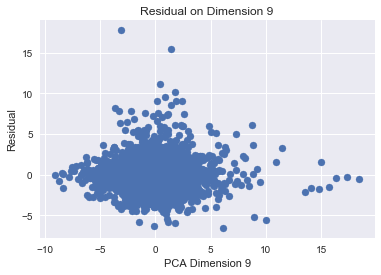

In [11]:
plt.hist(fitted_model.predict(pca_train_x),100)
plt.hist(fitted_model.predict(pca_test_x),100)
plt.title('Predicted Values')
plt.legend(['Training Set','Test Set'])
plt.xlabel('Predicted Murders per 10,000 People')
plt.ylabel('Count')
plt.show()

plt.hist(train_y,100)
plt.hist(test_y,100)
plt.title('Actual Values')
plt.legend(['Training Set','Test Set'])
plt.xlabel('Recorded Murders per 10,000 People')
plt.ylabel('Count')
plt.show()

resid = train_y - fitted_model.predict(pca_train_x)
plt.hist(resid,100)
resid = test_y - fitted_model.predict(pca_test_x)
plt.hist(resid,100)
plt.title('Residuals')
plt.legend(['Training Set','Test Set'])
plt.xlabel('Residual: Excess/Shortfall Number of Murders per 10,000 People')
plt.ylabel('Count')
plt.show()

#Training set residuals forever!
lasso_resid = train_y - fitted_model.predict(pca_train_x)

qqplot(lasso_resid, line='45')
plt.title("QQ plot of residuals")
plt.show()


for x in range(10):
    plt.scatter(pca_train_x[:,x],lasso_resid)
    plt.xlabel('PCA Dimension '+str(x))
    plt.ylabel('Residual')
    plt.title('Residual on Dimension '+str(x))
    plt.show()
    
lasso_test_resid = test_y - fitted_model.predict(pca_test_x)

The above graphs show that the model is predicting impossible murder rates (below zero) only rarely, but that the distribution of murder rates produced by the model is substantially different than the distribution in the real data.

The QQ plot shows that the residuals are much more heavy-tailed than a normal distribution, though the distribution of residuals is consistent in training set and in test set.

In the individual component plots it is clear that the residuals are heteroskedastic with apparently greater variance near 0 on each PCA component.

Overall, the graphs indicate that a GLM with heavier tails around the predicted value could fit the data more closely. Similarly, an appropriately scaled logistic regression could take into account that the dependent variable is bounded between 0 and 10,000.

In [12]:
#[Do not open until Thursday: see how well we do on test]

print("Test set R^2 score:",fitted_model.score(pca_test_x,test_y))

Test set R^2 score: 0.489819501618


Despite the data's limitations and quick-and-dirty, simplistic choices in model implementation, the model performs surprisingly well on the test set, about halfway between a predict-the-training-mean model and a perfect model.

Honestly, we can't fathom why this thing would be doing this well, and suspect some variable in the data is erroneously correlated with murder rate, e.g. becuase a crime statistic was scraped into a non-crime column name. But we can't find any such error in our work...

# Binomial Regression
Since the raw data are a a number of murders and a popoultion size, a Binomial GLM makes the most sense as a model. However, it is weakly supported in python, as statsmodels's implementation does not allow for regularization (we tried, but fit_regularized either it predicts the same value for every observation [contravarying the penalty] or hits numerical issues).

In [13]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM

percent_murdered_train = train_y/10000
percent_murdered_test = test_y/10000

number_murdered_train = np.round(train_x['msa_pop']*percent_murdered_train)
binomial_y = np.hstack([number_murdered_train.values.reshape(-1,1), train_x['msa_pop'].values.reshape(-1,1)])

const_pca_train_x = sm.add_constant(pca_train_x)
const_pca_test_x = sm.add_constant(pca_test_x)

# Instantiate a gamma family model with the default link function.
fitted_model = GLM(binomial_y, const_pca_train_x, family=sm.families.Binomial()).fit() #fit_regularized(alpha=.001, L1_wt=1)

fitted_model.predict(const_pca_train_x)

array([ 0.00022932,  0.00035274,  0.00044828, ...,  0.0005006 ,
        0.00032775,  0.00041275])

Binomial model average residual: 1.4485758123847678 
Lasso model average residual: 1.4437192998475101
Binomial model average test set residual: 1.611639165816759 
Lasso model average test set residual: 1.5804557280788794


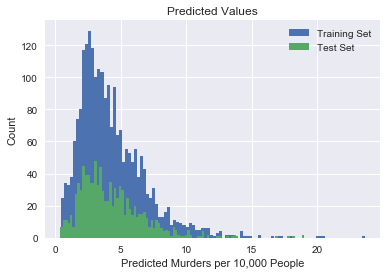

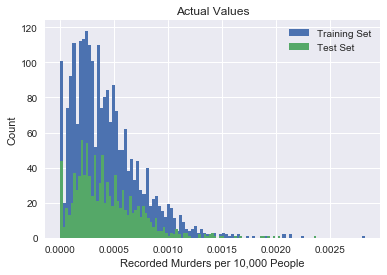

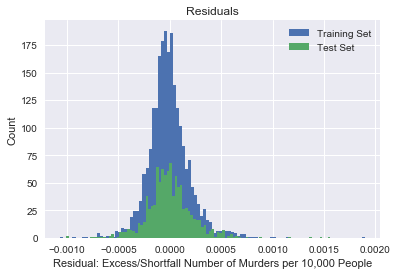

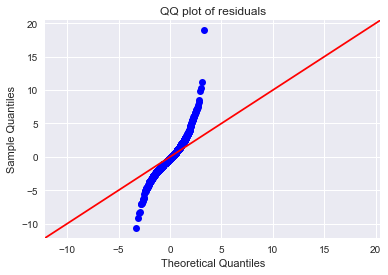

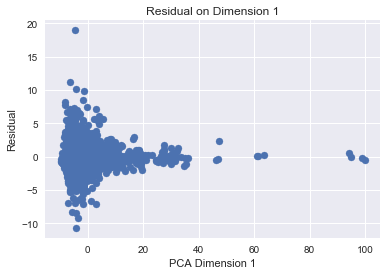

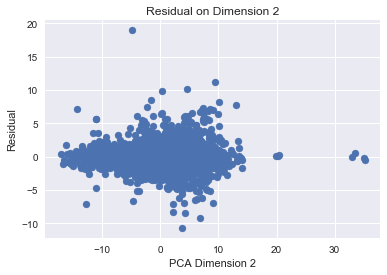

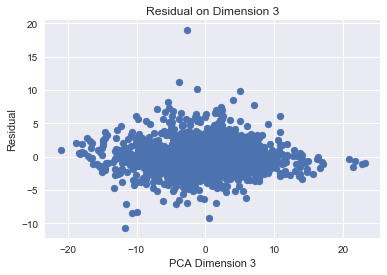

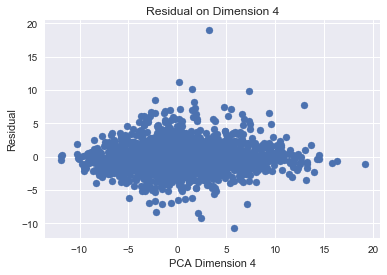

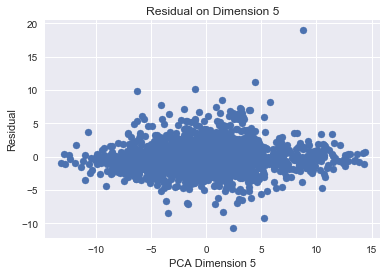

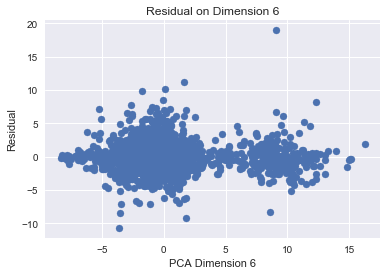

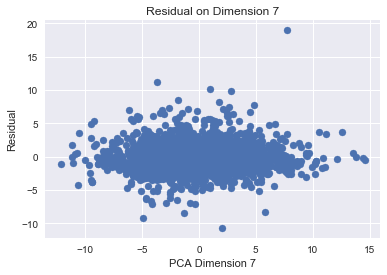

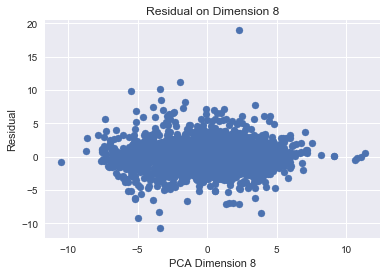

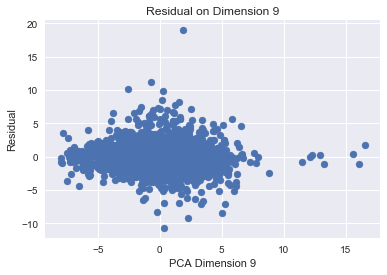

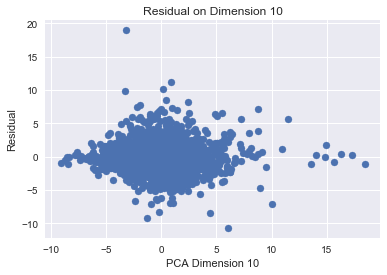

In [14]:
#binomial regression diagnostics
binomial_resid = 10000*(percent_murdered_train - fitted_model.predict(const_pca_train_x))
binomial_test_resid = 10000*(percent_murdered_test - fitted_model.predict(const_pca_test_x))
print("Binomial model average residual:", np.mean(np.abs(binomial_resid)),"\nLasso model average residual:",np.mean(np.abs(lasso_resid)))
print("Binomial model average test set residual:", np.mean(np.abs(binomial_test_resid)),"\nLasso model average test set residual:",np.mean(np.abs(lasso_test_resid)))


plt.hist(10000*fitted_model.predict(const_pca_train_x),100)
plt.hist(10000*fitted_model.predict(const_pca_test_x),100)
plt.title('Predicted Values')
plt.legend(['Training Set','Test Set'])
plt.xlabel('Predicted Murders per 10,000 People')
plt.ylabel('Count')
plt.show()

plt.hist(percent_murdered_train,100)
plt.hist(percent_murdered_test,100)
plt.title('Actual Values')
plt.legend(['Training Set','Test Set'])
plt.xlabel('Recorded Murders per 10,000 People')
plt.ylabel('Count')
plt.show()

resid = percent_murdered_train - fitted_model.predict(const_pca_train_x)
plt.hist(resid,100)
resid = percent_murdered_test - fitted_model.predict(const_pca_test_x)
plt.hist(resid,100)
plt.title('Residuals')
plt.legend(['Training Set','Test Set'])
plt.xlabel('Residual: Excess/Shortfall Number of Murders per 10,000 People')
plt.ylabel('Count')
plt.show()

#Training set residuals forever!
resid = 10000*(percent_murdered_train - fitted_model.predict(const_pca_train_x))

qqplot(resid, line='45')
plt.title("QQ plot of residuals")
plt.show()


for x in range(1,11): #skip the constant column
    plt.scatter(const_pca_train_x[:,x],resid)
    plt.xlabel('PCA Dimension '+str(x))
    plt.ylabel('Residual')
    plt.title('Residual on Dimension '+str(x))
    plt.show()

The plots above don't look any better than the simple linear regression, and the average (absolute) residual is about the same in both models. There is a slight indication thate the binomial regression is overfit due the a lack of regularization.

But hey, we can feel good about picking a model that matches the data's native distribution.